In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
from google.colab import files
uploaded = files.upload()


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import pandas as pd

data = pd.read_csv('train.csv')  # Adjust the filename if needed


In [ ]:
# Inspect the dataset
print("Dataset Overview:")
print(data.head())
print("\nDataset Info:")
data.info()

Dataset Overview:
                    qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [ ]:
# Preprocess the data
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

data['question_text'] = data['question_text'].apply(clean_text)

In [ ]:
# Extract features and labels
X = data['question_text']
y = data['target']  # Assuming 'target' column contains the labels

In [ ]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Tokenize and pad sequences
max_words = 20000  # Vocabulary size
max_len = 100  # Maximum length of sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2025-05-31 09:57:43--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2025-05-31 09:57:43--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2025-05-31 09:57:43--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]


In [ ]:
!unzip glove.42B.300d.zip

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
glove_path = 'glove.42B.300d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [ ]:
print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loaded 1917494 word vectors from GloVe.


In [ ]:
# Create embedding matrix
word_index = tokenizer.word_index
# Update the embedding dimension to match the GloVe file (e.g., 300)
embedding_dim = 300

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential()

# Embedding layer with pre-trained GloVe embeddings
model.add(Embedding(
    input_dim=max_words,           # Size of the vocabulary
    output_dim=embedding_dim,      # Dimensionality of embeddings (e.g., 300)
    weights=[embedding_matrix],    # Pre-trained GloVe matrix
    input_length=max_len,          # Max input length (padded sequence length)
    trainable=False                # Set to True if you want to fine-tune embeddings
))

# LSTM layer (Bidirectional optional)
# model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [ ]:
# Train the model
batch_size = 32
epochs = 2

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/2
32654/32654 ━━━━━━━━━━━━━━━━━━━━ 10111s 309ms/step - accuracy: 0.9501 - loss: 0.1310 - val_accuracy: 0.9581 - val_loss: 0.1074
Epoch 2/2
32654/32654 ━━━━━━━━━━━━━━━━━━━━ 11316s 345ms/step - accuracy: 0.9567 - loss: 0.1101 - val_accuracy: 0.9593 - val_loss: 0.1036


In [ ]:
# Evaluate the model
val_pred = (model.predict(X_val_pad) > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_val, val_pred))

8164/8164 ━━━━━━━━━━━━━━━━━━━━ 644s 79ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    245369
           1       0.69      0.59      0.64     15856

    accuracy                           0.96    261225
   macro avg       0.83      0.79      0.81    261225
weighted avg       0.96      0.96      0.96    261225



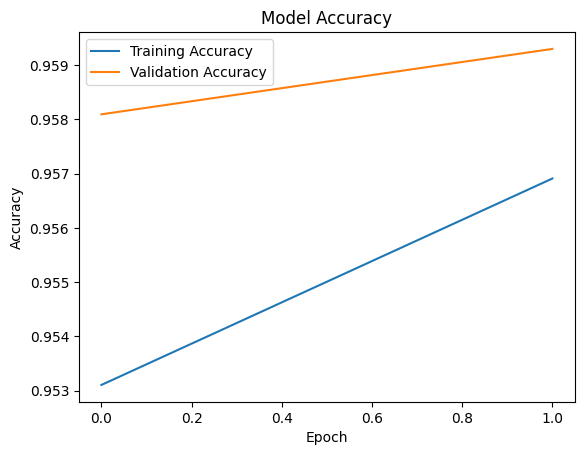

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()